# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review



# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

In [2]:
# using SQLite table to access the cleaned text. Cleaned Text means 
#Preprocessed data which has been lemmatized and Stemming etc.
con = sqlite3.connect('C:/Users/vinay/knn/final1.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (364171, 12)


# Sorting the data according to time stamp

In [3]:
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
sorted_data.shape

(364171, 12)

###  in knn algorithm has memory problem (if data is large ) so we take 1lakh data points form the sorted_data.

In [12]:
# i took 100k reviews.
sorted_data=sorted_data[0:100000]
sorted_data['Score'].value_counts()

positive    87729
negative    12271
Name: Score, dtype: int64

In [20]:
#Importing all the necessary packages for performing Knn.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score

In [18]:
X = sorted_data.CleanedText.values
y = sorted_data.Score.values 
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.25, random_state=0)
# split the data into Train and Test



In [19]:
from sklearn.preprocessing import LabelBinarizer
lb= LabelBinarizer()
y_train=np.array([number[0] for number in lb.fit_transform(y_train)])
print(y_train)

[1 1 1 ... 1 1 1]


In [38]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB

#def naivebayes(X_train,y_train,X_test,y_test,Vectorization):
    lb= LabelBinarizer()
    y_train=np.array([number[0] for number in lb.fit_transform(y_train)])
    y_test=np.array([number[0] for number in lb.fit_transform(y_test)])
    alpha1=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    cv_scores=[]
    for optimal_alpha in alpha1:
        NB=MultinomialNB(alpha=optimal_alpha)
        scores = cross_val_score(NB,X_train, y_train, cv=10, scoring='f1')
        cv_scores.append(scores.mean())
    MSE = [1 - x for x in cv_scores]  #miss classification error
    # determining best k
    optimal_k = alpha1[MSE.index(min(MSE))]
    #print('\nThe optimal number of neighbors is %d.' % optimal_k)
       
    print(X_test.shape)   
    print(X_train.shape)
    good_NB = MultinomialNB(alpha=optimal_k)
    # fitting the model
    good_NB.fit(X_train, y_train)

    predict=good_NB.predict(X_test)
    acc = accuracy_score(y_test, predict) * 100
    score=good_NB.score(X_test, y_test)
    
    neg_class_prob = good_NB.feature_log_prob_[0, :].argsort() # getting the negative words propabilities.
    pos_class_prob = good_NB.feature_log_prob_[1, :].argsort() # getting the positive words propabilities.
    print('\n')
    print('Details for',Vectorization,'vectorization')
    print('*'*40)
    #pred=good_NB.predict(X_test)
    from sklearn import metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, predict)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('\n')
    print('The F1 scoring on Test data is:', score)
    print('\n')
    print('Accuracy for MultinomialNB algorithm with alpha value =',optimal_k,', calculated using F1 as scoring metric is ' ,np.round(accuracy_score(y_test, predict)*100))  
    print('missclassification error for each alpha=',np.round(MSE,3))
    print('\n')
    print('f1 score for NB algorithm with alpha =',optimal_k,' is ' , np.round((f1_score(y_test, predict,average= 'macro')*100),decimals = 2))
    print('\n')
    print('Recall for NB agorithm with alpha =',optimal_alpha,' is ' , np.round((recall_score(y_test, predict,average= 'macro')*100),decimals = 2))
    print('\n')
    print('Precision for NB algorithm with aplha =',optimal_alpha,' is ' , np.round((precision_score(y_test, predict,average= 'macro')*100),decimals = 2))
    print('\n')
    print ('\n Classification report for MultinomialNB algorithm with alpha =',optimal_k,' is \n ' , classification_report(y_test,predict))
    cm = confusion_matrix(y_test, predict)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show() 
    print('The accuracy of the NB classifier for alpha =%f is %f%%' % (optimal_k, acc))
    print('\n Top negative values')
    print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob[:10])) 
    print('\n Top positive values')
    print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob[:10]))    
   
    return good_NB



# [4] Featurization

## [4.1]  Naive Bayes on BAG OF WORDS

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() 
count_vect.fit(X_train)
train_bow    =count_vect.transform(X_train)
cv_bow       =count_vect.transform(X_cv)
# Here we fit transform to the data
cv_bow.get_shape() # We can see that the data has 70k rows and max 500 features columns(unique words).


(20000, 29394)

In [23]:
test_bow     =count_vect.transform(X_test)
test_bow.get_shape()

(20000, 29394)

In [45]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB

def naivebayes(X_train,y_train,X_cv,y_cv,X_test,y_test,Vectorization):
    lb= LabelBinarizer()
    y_train=np.array([number[0] for number in lb.fit_transform(y_train)])
    y_test=np.array([number[0] for number in lb.fit_transform(y_test)])
    alpha1=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    cv_scores=[]
    for optimal_alpha in alpha1:
        NB=MultinomialNB(alpha=optimal_alpha)
        scores = cross_val_score(NB,X_train, y_train, cv=10, scoring='f1')
        cv_scores.append(scores.mean())
    MSE = [1 - x for x in cv_scores]  #miss classification error
    # determining best k
    optimal_k = alpha1[MSE.index(min(MSE))]
    #print('\nThe optimal number of neighbors is %d.' % optimal_k)
       
    print(X_test.shape)   
    print(X_train.shape)
    good_NB = MultinomialNB(alpha=optimal_k)
    # fitting the model
    good_NB.fit(X_train, y_train)

    predict=good_NB.predict(X_test)
    acc = accuracy_score(y_test, predict) * 100
    score=good_NB.score(X_test, y_test)
    
    neg_class_prob = good_NB.feature_log_prob_[0, :].argsort() # getting the negative words propabilities.
    pos_class_prob = good_NB.feature_log_prob_[1, :].argsort() # getting the positive words propabilities.
    print('\n')
    print('Details for',Vectorization,'vectorization')
    print('*'*40)
    #pred=good_NB.predict(X_test)
    from sklearn import metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, predict)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('\n')
    print('The F1 scoring on Test data is:', score)
    print('\n')
    print('Accuracy for MultinomialNB algorithm with alpha value =',optimal_k,', calculated using F1 as scoring metric is ' ,np.round(accuracy_score(y_test, predict)*100))  
    print('missclassification error for each alpha=',np.round(MSE,3))
    print('\n')
    print('f1 score for NB algorithm with alpha =',optimal_k,' is ' , np.round((f1_score(y_test, predict,average= 'macro')*100),decimals = 2))
    print('\n')
    print('Recall for NB agorithm with alpha =',optimal_alpha,' is ' , np.round((recall_score(y_test, predict,average= 'macro')*100),decimals = 2))
    print('\n')
    print('Precision for NB algorithm with aplha =',optimal_alpha,' is ' , np.round((precision_score(y_test, predict,average= 'macro')*100),decimals = 2))
    print('\n')
    print ('\n Classification report for MultinomialNB algorithm with alpha =',optimal_k,' is \n ' , classification_report(y_test,predict))
    cm = confusion_matrix(y_test, predict)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show() 
    cm = confusion_matrix(y_cv, predict)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    print('The accuracy of the NB classifier for alpha =%f is %f%%' % (optimal_k, acc))
    print('\n Top negative values')
    print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob[:10])) 
    print('\n Top positive values')
    print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob[:10]))    
   
    return good_NB



(20000, 29394)
(60000, 29394)


Details for Bag of Words vectorization
****************************************


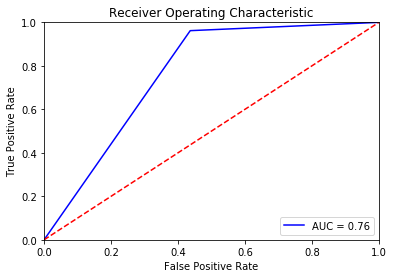



The F1 scoring on Test data is: 0.91335


Accuracy for MultinomialNB algorithm with alpha value = 1 , calculated using F1 as scoring metric is  91.0
missclassification error for each alpha= [0.059 0.059 0.058 0.058 0.053 0.064 0.066 0.066 0.066]


f1 score for NB algorithm with alpha = 1  is  78.21


Recall for NB agorithm with alpha = 10000  is  76.27


Precision for NB algorithm with aplha = 10000  is  80.63



 Classification report for MultinomialNB algorithm with alpha = 1  is 
               precision    recall  f1-score   support

          0       0.67      0.56      0.61      2435
          1       0.94      0.96      0.95     17565

avg / total       0.91      0.91      0.91     20000



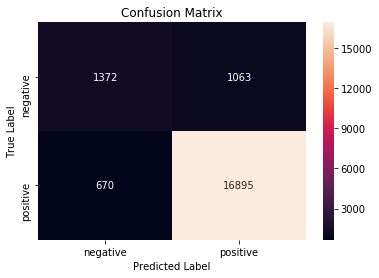

TypeError: '<' not supported between instances of 'int' and 'str'

In [46]:
%%time
from sklearn.naive_bayes import MultinomialNB
NBbow=naivebayes(train_bow,y_train,cv_bow,y_cv,test_bow,y_test,'Bag of Words')

# [4.2] Naive Bayes on  TFIDF 

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) #,min_df=10,max_df=300)
train_tfidf    =tf_idf_vect.fit_transform(X_train)
#cv_tfidf       =tf_idf_vect.transform(X_cv)
train_tfidf.get_shape()

(70000, 936479)

In [47]:
test_tfidf  =tf_idf_vect.transform(X_test)
test_tfidf.get_shape()

(30000, 936479)

(30000, 936479)
(70000, 936479)


Details for tfidf vectorization
****************************************


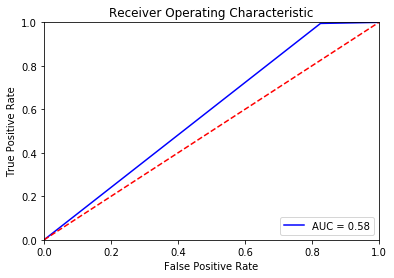



The F1 scoring on Test data is: 0.8943666666666666


Accuracy for MultinomialNB algorithm with alpha value = 0.0001 , calculated using F1 as scoring metric is  89.0
missclassification error for each alpha= [0.056 0.059 0.076 0.056 0.065 0.065 0.065 0.065 0.065]


f1 score for NB algorithm with alpha = 0.0001  is  61.56


Recall for NB agorithm with alpha = 10000  is  58.47


Precision for NB algorithm with aplha = 10000  is  86.49



 Classification report for MultinomialNB algorithm with alpha = 0.0001  is 
               precision    recall  f1-score   support

          0       0.83      0.17      0.29      3683
          1       0.90      1.00      0.94     26317

avg / total       0.89      0.89      0.86     30000



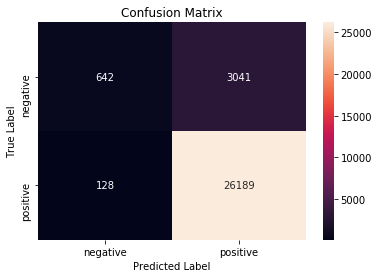

The accuracy of the NB classifier for alpha =0.000100 is 89.436667%

 Top negative values
['aaa' 'oxid quick' 'oxid right' 'oxid rooibo' 'oxid spell' 'oxid spread'
 'oxid thermogenesi' 'oxid thiamin' 'oxid time' 'oxid turn']

 Top positive values
['say mild' 'rise lot' 'cart fulfil' 'inde charg' 'inde break' 'cart cent'
 'rise product' 'rise ridicul' 'rise scorch' 'rise see']
Wall time: 55.5 s


In [67]:
%%time
NBtfidf=naivebayes(train_tfidf,y_train,test_tfidf,y_test,'tfidf')

In [50]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Name", "Hyper Parameter(alpha)", "Accuracy"]

In [62]:
x.add_row(["MultinomialNB on BoW",1,90.94])
x.add_row(["MultinomialNB on TfIdf",0.0001,89.43])
print(x)


+------------------------+------------------------+----------+
|       Model Name       | Hyper Parameter(alpha) | Accuracy |
+------------------------+------------------------+----------+
|  MultinomialNB on BoW  |           1            |  90.94   |
| MultinomialNB on TfIdf |         0.0001         |  89.43   |
+------------------------+------------------------+----------+


# Conclusion:
<ul>After performing Bow and Tf-Idf on all the one lakh reviews, Multinomial Naive Bayes gives same accuracy.</ul>